In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight 

import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

import yaml

[nltk_data] Downloading package stopwords to C:\Users\Fillipe
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [4]:
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])

In [5]:
base = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)
base.head()

,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [75]:
base_train_val = base.copy().drop(['image_name', 'humour', 'sarcasm', 'offensive', 'motivational'], axis = 1)
base_train_val.target.replace("very_positive", 
           "positive", 
           inplace=True)
base_train_val.target.replace("very_negative", 
           "negative", 
           inplace=True)   
base_train_val['num_target'] = base_train_val.target.astype('category').cat.codes    
base_train_val.head()

,text,target,num_target
0,if you want to view paradis simpli look around...,positive,2
1,if i had a brick for everi lie hillari told i ...,positive,2
2,that thing over there can i eat that,positive,2
3,my dad point to liam and said when did david b...,neutral,1
4,probabl the first man to do year challeng chen...,negative,0


# Baselines


## Modelo 1: TF-IDF + SVM

In [76]:
train, val = train_test_split(base_train_val, test_size=0.2, random_state=SEED)
train.head()

,text,target,num_target
4223,doe anyon els wish we could trade these peopl ...,positive,2
1202,obama run from spooki meme,negative,0
3262,today is nation best friend day lovecasm tall ...,positive,2
4683,i dont know if you got ani of that but id real...,positive,2
2600,be care who you make fun of in high school,positive,2


## Modelo TF-IDF + SVM (desbalanceado)

In [77]:
stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(
                              stop_words = stop_words,
                              smooth_idf=True, # impede a divisão zero para palavras não vistas
                              max_features = 500
                              )

In [78]:
#Treino
list_text = train.text.tolist()
X_train = tfidf_vectorizer.fit_transform(list_text).toarray()
y_train = train.num_target

#Validação
list_text = val.text.tolist()
X_val = tfidf_vectorizer.transform(list_text).toarray()
y_val = val.num_target

In [79]:
kernels = ['linear', 'rbf'] 
CArray = np.logspace(-1,3,5)
gammaArray= list(np.logspace(0,-4,5))

param_grid = dict(C=CArray, gamma=gammaArray, kernel = kernels)

clf_svc = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy',verbose=3)
clf_svc.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.596 total time=   5.7s
[CV 2/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.596 total time=   6.5s
[CV 3/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.596 total time=   4.9s
[CV 4/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.595 total time=   4.6s
[CV 5/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.595 total time=   4.8s
[CV 1/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.596 total time=   6.8s
[CV 2/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.596 total time=   6.8s
[CV 3/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.596 total time=   6.9s
[CV 4/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.595 total time=   6.9s
[CV 5/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.595 total time=   6.9s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.596 total time=   4.7s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': [1.0, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

In [80]:
clf_svc.best_estimator_

SVC(C=0.1, gamma=1.0, kernel='linear')

In [81]:
y_pred = clf_svc.predict(X_train)
print("Treino - balanced_accuracy : ", balanced_accuracy_score(y_train,  y_pred))
print("Treino - F1 : ", f1_score(y_train, y_pred, average='macro'))

Treino - balanced_accuracy :  0.3333333333333333
Treino - F1 :  0.24885057471264369


In [82]:
y_pred = clf_svc.predict(X_val)
print("Validacao - balanced_accuracy : ", balanced_accuracy_score(y_val,  y_pred))
print("Treino - F1 : ", f1_score(y_val, y_pred, average='macro'))

Validacao - balanced_accuracy :  0.3333333333333333
Treino - F1 :  0.2496177370030581


In [83]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(y_val, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

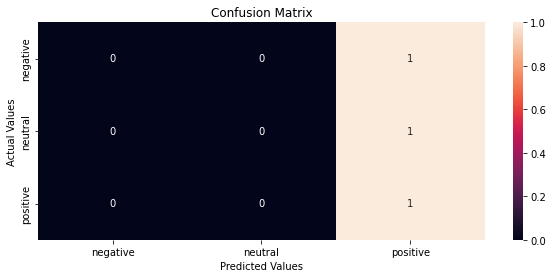

In [84]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(y_val, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Modelo TF-IDF + SVM (balanceado)

### Balanceamento por ponderacao da funcao de erro

In [85]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(y_train) ,y = y_train).ravel()
class_weights = dict((i,v) for i, v in enumerate(weights))
class_weights

{0: 3.5901234567901232, 1: 1.0699043414275202, 2: 0.5596612779060816}

In [86]:
kernels = ['linear', 'rbf'] 
CArray = np.logspace(-1,3,5)
gammaArray= list(np.logspace(0,-4,5))

param_grid = dict(C=CArray, gamma=gammaArray, kernel = kernels)

clf_svc_balanced = GridSearchCV(SVC(class_weight = class_weights), param_grid, cv=5, scoring='accuracy',verbose=3)
clf_svc_balanced.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.290 total time=   5.4s
[CV 2/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.355 total time=   5.4s
[CV 3/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.328 total time=   5.3s
[CV 4/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.414 total time=   5.3s
[CV 5/5] END ...C=0.1, gamma=1.0, kernel=linear;, score=0.417 total time=   5.3s
[CV 1/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.131 total time=   6.3s
[CV 2/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.293 total time=   6.3s
[CV 3/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.180 total time=   6.3s
[CV 4/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.592 total time=   6.4s
[CV 5/5] END ......C=0.1, gamma=1.0, kernel=rbf;, score=0.593 total time=   6.3s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.290 total time=   5.3s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear

GridSearchCV(cv=5,
             estimator=SVC(class_weight={0: 3.5901234567901232,
                                         1: 1.0699043414275202,
                                         2: 0.5596612779060816}),
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': [1.0, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

In [87]:
clf_svc_balanced.best_estimator_

SVC(C=100.0,
    class_weight={0: 3.5901234567901232, 1: 1.0699043414275202,
                  2: 0.5596612779060816},
    gamma=1.0)

In [88]:
y_pred = clf_svc_balanced.predict(X_train)
print("Treino - balanced_accuracy : ", balanced_accuracy_score(y_train,  y_pred))
print("Treino - F1 : ", f1_score(y_train, y_pred, average='macro'))

Treino - balanced_accuracy :  0.9624414773123152
Treino - F1 :  0.9418812246406411


In [89]:
y_pred = clf_svc_balanced.predict(X_val)
print("Validacao - balanced_accuracy : ", balanced_accuracy_score(y_val,  y_pred))
print("Treino - F1 : ", f1_score(y_val, y_pred, average='macro'))

Validacao - balanced_accuracy :  0.3215390518477598
Treino - F1 :  0.31454694344443684


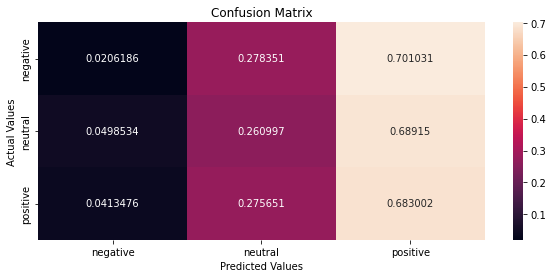

In [90]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(y_val, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()